<a href="https://colab.research.google.com/github/zachwaldron4/NeuralNets/blob/master/CHAMP_density_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install tensorflow-gpu==2.0.0-alpha0

In [0]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or 

In [0]:
# # Data comes from:
# # https://finance.yahoo.com/quote/BTC-USD/history?period1=1279314000&period2=1556053200&interval=1d&filter=history&frequency=1d

# csv_path = "https://raw.githubusercontent.com/curiousily/Deep-Learning-For-Hackers/master/data/3.stock-prediction/BTC-USD.csv"
# # csv_path = "https://raw.githubusercontent.com/curiousily/Deep-Learning-For-Hackers/master/data/3.stock-prediction/AAPL.csv"

In [0]:
# from google.colab import files
# uploaded = files.upload()


# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
## After executing the cell above, Drive
## files will be present in "/content/drive/My Drive".
!ls "/content/drive/My Drive/data"

champ_ts_pickle.pkl  short_champ_ts_pickle.pkl


In [0]:
import io
df = pd.read_pickle('/content/drive/My Drive/data/short_champ_ts_pickle.pkl')
# Dataset is now stored in a Pandas Dataframe



In [0]:
df = df.sort_values('date')

In [0]:
df.head()

,date,rho,time_full,slt_full,lon_full,lat_full
0,2002-01-02 00:00:10,6.156611e-12,0.002778,16.028768,-119.555981,84.853098
1,2002-01-02 00:01:00,4.673083e-12,0.016667,18.389313,-84.356145,87.049421
2,2002-01-02 00:01:45,4.423064e-12,0.029167,22.105051,-28.807572,86.755793
3,2002-01-02 00:02:40,3.320804e-12,0.044444,0.102967,0.932003,84.028323
4,2002-01-02 00:03:30,4.407398e-12,0.058333,0.735702,10.214692,81.035098


In [0]:
df.shape

(2665542, 6)

In [0]:
# ax = df.plot(x='Date', y='Close');
# ax.set_xlabel("Date")
# ax.set_ylabel("Close Price (USD)")

# Normalization

In [0]:
scaler = MinMaxScaler()

rho = df.rho.values.reshape(-1, 1)

scaled_rho = scaler.fit_transform(rho)

In [0]:
scaled_rho.shape

(2665542, 1)

In [0]:
np.isnan(scaled_rho).any()

False

In [0]:
scaled_rho = scaled_rho[~np.isnan(scaled_rho)]

In [0]:
scaled_rho = scaled_rho.reshape(-1, 1)

In [0]:
np.isnan(scaled_rho).any()

False

# Preprocessing

In [0]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_rho, SEQ_LEN, train_split = 0.95)

In [0]:
X_train.shape

(2532169, 99, 1)

In [0]:
X_test.shape

(133273, 99, 1)

# Model

In [0]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = keras.Sequential()

model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(CuDNNLSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=False)))

model.add(Dense(units=1))

model.add(Activation('linear'))

# Training

In [0]:
model.compile(
    loss='mean_squared_error', 
    optimizer='adam'
)

In [0]:
BATCH_SIZE = 500

history = model.fit(
    X_train, 
    y_train, 
    epochs=10, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)

Train on 2278952 samples, validate on 253217 samples
Epoch 1/10
2278952/2278952 [==============================] - 701s 307us/sample - loss: 2.4635e-04 - val_loss: 6.9456e-05
Epoch 2/10
2278952/2278952 [==============================] - 704s 309us/sample - loss: 1.4578e-04 - val_loss: 3.9081e-05
Epoch 3/10
2278952/2278952 [==============================] - 702s 308us/sample - loss: 9.8210e-05 - val_loss: 1.9105e-05
Epoch 4/10
2278952/2278952 [==============================] - 704s 309us/sample - loss: 8.9797e-05 - val_loss: 1.5467e-05
Epoch 5/10
2278952/2278952 [==============================] - 705s 309us/sample - loss: 7.2938e-05 - val_loss: 1.6917e-05
Epoch 6/10
2278952/2278952 [==============================] - 702s 308us/sample - loss: 7.6427e-05 - val_loss: 1.6020e-05
Epoch 7/10
2278952/2278952 [==============================] - 704s 309us/sample - loss: 6.8409e-05 - val_loss: 1.9147e-05
Epoch 8/10
2278952/2278952 [==============================] - 702s 308us/sample - loss: 7.767

In [0]:
model.evaluate(X_test, y_test)

133273/133273 [==============================] - 78s 586us/sample - loss: 9.4002e-06


9.40022786120499e-06

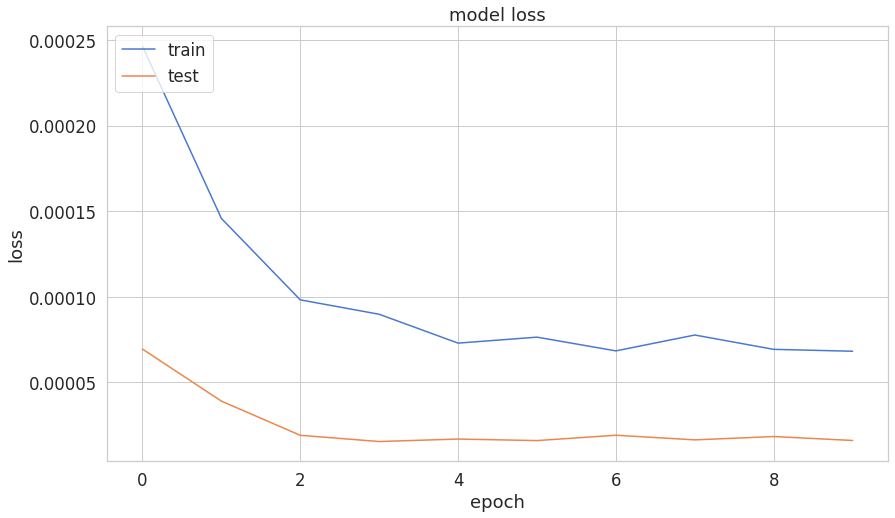

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Prediction

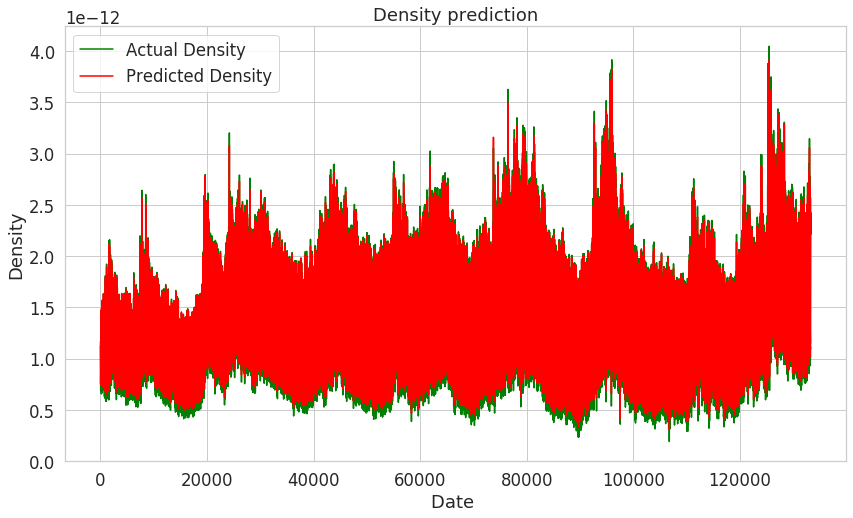

In [0]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Density", color='green')
plt.plot(y_hat_inverse, label="Predicted Density", color='red')
 
plt.title('Density prediction')
plt.xlabel('Date ')
plt.ylabel('Density')
plt.legend(loc='best')
 
plt.show();